In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import GPUtil
import tree
from openfold.utils import rigid_utils as ru
from scipy.spatial.transform import Rotation
from omegaconf import OmegaConf
import importlib
import logging
import sys
from collections import defaultdict
import matplotlib.cm as cm


from analysis import utils as au
from analysis import plotting
from data import utils as du
from data import se3_diffuser
from data import so3_diffuser
from data import r3_diffuser
from data import digs_data_loader
from model import loss
from experiments import train_se3_diffusion

# Enable logging
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

INFO: Using numpy backend
INFO: Note: detected 80 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO: Note: NumExpr detected 80 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: NumExpr defaulting to 8 threads.


In [2]:
# Reloads any code changes in the source file.
importlib.reload(digs_data_loader)
importlib.reload(se3_diffuser)
importlib.reload(so3_diffuser)
importlib.reload(r3_diffuser)
importlib.reload(du)
importlib.reload(plotting)
importlib.reload(train_se3_diffusion)

<module 'experiments.train_se3_diffusion' from '/data/rsg/chemistry/jyim/projects/protein_diffusion/experiments/train_se3_diffusion.py'>

In [8]:
# Load config.
conf = OmegaConf.load('../config/base.yaml')

# Redirect cache from notebook directory.
exp_conf = conf.experiment
exp_conf.data_location = 'rosetta'
exp_conf.ckpt_dir = None
exp_conf.num_loader_workers = 0
exp_conf.dist_mode = 'single'
exp_conf.use_wandb = False

# Data settings
data_conf = conf.data
# data_conf.rosetta.filtering.subset = 1

diff_conf = conf.diffuser
diff_conf.se3.r3.min_b = 0.1
diff_conf.se3.so3.min_sigma = 0.02

# Figure out data loading for PDB on rosetta
exp = train_se3_diffusion.Experiment(conf=conf)
train_loader, valid_loader = exp.create_rosetta_dataset(0, 1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
exp._model = exp._model.to(device)

INFO: Using cached IGSO3.
INFO: Number of model parameters 15402858
INFO: Checkpoint not being saved.
INFO: Evaluation saved to: ./results/baseline/27D_10M_2022Y_08h_30m_00s
INFO: Training: 10172 examples
INFO: Validation: 40 examples with lengths [ 60  82 104 126 148 171 193 215 237 260]


In [9]:
diff_conf

{'seq': {'diffuse_seq': True, 'min_b': 15.0, 'max_b': 20.0, 'schedule': 'linear'}, 'se3': {'diffuse_trans': True, 'diffuse_rot': True, 'r3': {'min_b': 0.1, 'max_b': 20.0, 'schedule': 'linear', 'score_scaling': 'std', 'coordinate_scaling': 0.1}, 'so3': {'num_omega': 1000, 'num_sigma': 1000, 'min_sigma': 0.02, 'max_sigma': 1.5, 'schedule': 'logarithmic', 'equivariant_score': False, 'cache_dir': './pkl_jar/', 'score_scaling': 'std'}}}

In [10]:
so3_diff = exp.diffuser.se3_diffuser._so3_diffuser
r3_diff = exp.diffuser.se3_diffuser._r3_diffuser

In [11]:
r3_diff.b_t(0.1)

2.09

In [12]:
so3_diff.sigma(0.1)

0.31214303362124357

In [25]:
np.sqrt(1 - np.exp(-r3_diff.marginal_b_t(0.1)))

0.3220525355247045

In [28]:
np.exp(-1/2*r3_diff.marginal_b_t(0.))

0.8113952356434114

### Visualize std

In [57]:
r3_diff = exp.diffuser.se3_diffuser._r3_diffuser

In [92]:
r3_conf = conf.diffuser.se3.r3
r3_conf.min_b = 4.0
r3_conf.max_b = 20.0
r3_diff = r3_diffuser.R3Diffuser(r3_conf)

In [93]:
ts = np.linspace(1e-3, 1, 100)
std_ts = np.sqrt(1 - np.exp(-r3_diff.marginal_b_t(ts)))
mu_ts = np.exp(-1/2*r3_diff.marginal_b_t(ts))

Text(0, 0.5, 'std')

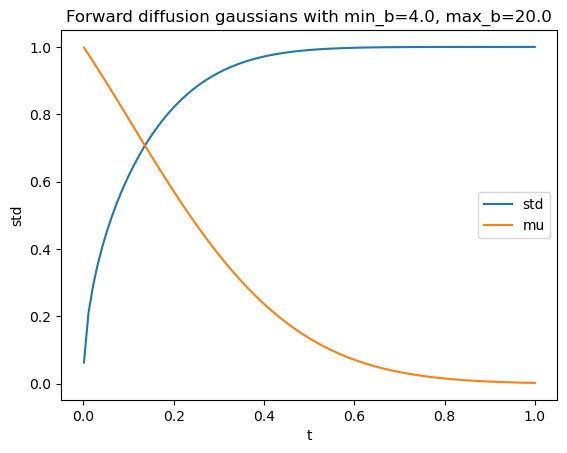

In [94]:
plt.plot(ts, std_ts, label='std')
plt.plot(ts, mu_ts, label='mu')
plt.legend()
plt.title(f'Forward diffusion gaussians with min_b={r3_conf.min_b}, max_b={r3_conf.max_b}')
plt.xlabel('t')
plt.ylabel('std')

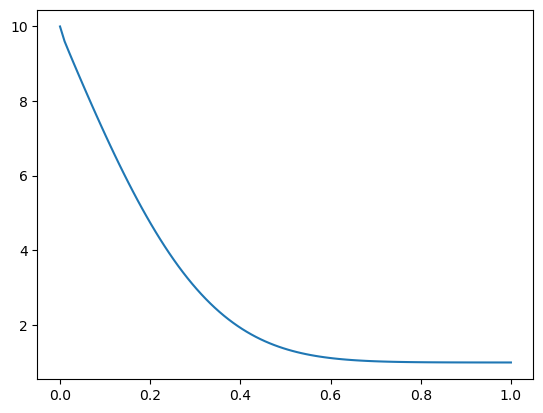

In [13]:
scale_factor = std_ts + 10 * (1 - std_ts)
plt.plot(ts, scale_factor)

### Data investigation

In [4]:
train_loader, valid_loader = exp.create_rosetta_dataset(0, 1)

INFO: Training: 10172 examples
INFO: Validation: 40 examples with lengths [ 60  82 104 126 148 171 193 215 237 260]


In [5]:
train_csv = train_loader.dataset.csv

In [6]:
train_csv.head()

,pdb_name,processed_path,raw_path,oligomeric_count,oligomeric_detail,resolution,structure_method,num_chains,quaternary_category,seq_len,modeled_seq_len,coil_percent,helix_percent,strand_percent,radius_gyration
11805,5n9s,/data/rsg/chemistry/jyim/large_data/processed_...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,1,monomeric,2.30,x-ray diffraction,1,homomer,327,260,0.430769,0.365385,0.203846,1.928871
37571,6ah9,/data/rsg/chemistry/jyim/large_data/processed_...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,1,monomeric,1.74,x-ray diffraction,1,homomer,406,260,0.373077,0.496154,0.130769,1.791267
1735,4awn,/data/rsg/chemistry/jyim/large_data/processed_...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,1,monomeric,1.95,x-ray diffraction,2,heteromer,476,260,0.434615,0.284615,0.280769,1.779229
11806,5n93,/data/rsg/chemistry/jyim/large_data/processed_...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,1,monomeric,2.10,x-ray diffraction,1,homomer,319,260,0.423077,0.361538,0.215385,1.914636
15794,6yg4,/data/rsg/chemistry/jyim/large_data/processed_...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,1,monomeric,2.30,x-ray diffraction,1,homomer,301,260,0.403846,0.407692,0.188462,1.951594


In [20]:
train_csv[train_csv['coil_percent'] == train_csv['coil_percent'].max()]

,pdb_name,processed_path,raw_path,oligomeric_count,oligomeric_detail,resolution,structure_method,num_chains,quaternary_category,seq_len,modeled_seq_len,coil_percent,helix_percent,strand_percent,radius_gyration
12143,2q3w,/data/rsg/chemistry/jyim/large_data/processed_...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,1,monomeric,1.48,x-ray diffraction,1,homomer,248,109,4.321101,0.302752,3.376147,1.355368


In [21]:
train_csv[train_csv['coil_percent'] < 0.5]

(12597, 15)

In [ ]:
train_csv

In [14]:
print(train_csv[['pdb_name', 'coil_percent', 'modeled_seq_len']])

      pdb_name  coil_percent  modeled_seq_len
11805     5n9s      0.430769              260
37571     6ah9      0.373077              260
1735      4awn      0.434615              260
11806     5n93      0.423077              260
15794     6yg4      0.403846              260
...        ...           ...              ...
24751     5yj8      0.366667               60
11343     5n35      0.283333               60
12511     5fwb      0.483333               60
6661      2xmf      0.466667               60
2138      5n41      0.266667               60

[10172 rows x 3 columns]


In [16]:
train_csv[train_csv.modeled_seq_len == 125]

,pdb_name,processed_path,raw_path,oligomeric_count,oligomeric_detail,resolution,structure_method,num_chains,quaternary_category,seq_len,modeled_seq_len,coil_percent,helix_percent,strand_percent,radius_gyration
13854,2zoi,/data/rsg/chemistry/jyim/large_data/processed_...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,1,monomeric,1.500,neutron diffraction,1,homomer,199,125,0.400,0.304,0.296,1.318660
32851,6p1f,/data/rsg/chemistry/jyim/large_data/processed_...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,1,monomeric,1.650,x-ray diffraction,1,homomer,231,125,0.448,0.000,0.552,1.419922
2703,3pyp,/data/rsg/chemistry/jyim/large_data/processed_...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,1,monomeric,0.850,x-ray diffraction,1,homomer,263,125,0.384,0.320,0.296,1.348096
6818,1jug,/data/rsg/chemistry/jyim/large_data/processed_...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,1,monomeric,1.900,x-ray diffraction,1,homomer,191,125,0.496,0.392,0.112,1.387343
6593,2qdb,/data/rsg/chemistry/jyim/large_data/processed_...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,1,monomeric,2.200,x-ray diffraction,1,homomer,162,125,0.368,0.288,0.344,1.398385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39982,1prq,/data/rsg/chemistry/jyim/large_data/processed_...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,1,monomeric,2.500,x-ray diffraction,1,homomer,181,125,0.328,0.344,0.328,1.313932
48314,3rdq,/data/rsg/chemistry/jyim/large_data/processed_...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,1,monomeric,1.600,x-ray diffraction,1,homomer,269,125,0.400,0.064,0.536,1.562761
8734,1f98,/data/rsg/chemistry/jyim/large_data/processed_...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,1,monomeric,1.150,x-ray diffraction,1,homomer,235,125,0.400,0.304,0.296,1.368348
34951,5gx9,/data/rsg/chemistry/jyim/large_data/processed_...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,1,monomeric,1.493,neutron diffraction,1,homomer,206,125,0.400,0.304,0.296,1.349581


Text(0.5, 1.0, 'Sequence length histogram after filtering')

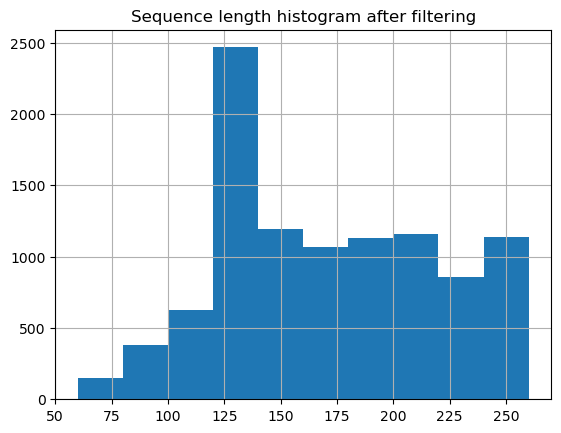

In [15]:
ax = train_csv.modeled_seq_len.hist()
ax.set_title('Sequence length histogram after filtering')

Text(0.5, 1.0, 'Coil percent histogram after filtering')

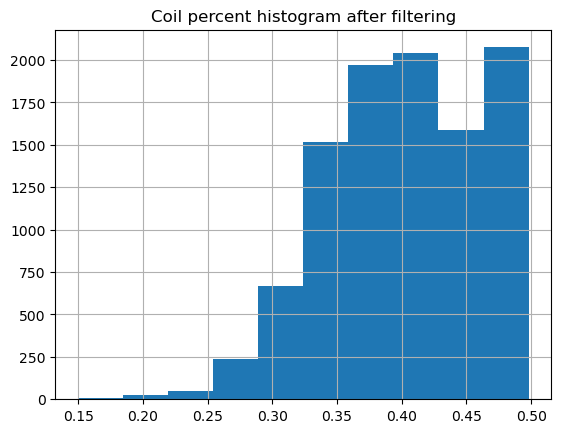

In [10]:
ax = train_csv.coil_percent.hist()
ax.set_title('Coil percent histogram after filtering')

Text(0.5, 1.0, 'Strand percent histogram after filtering')

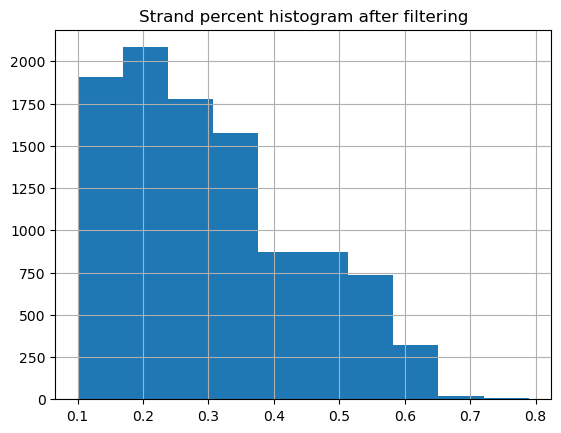

In [11]:
ax = train_csv.strand_percent.hist()
ax.set_title('Strand percent histogram after filtering')

Text(0.5, 1.0, 'Helix percent histogram after filtering')

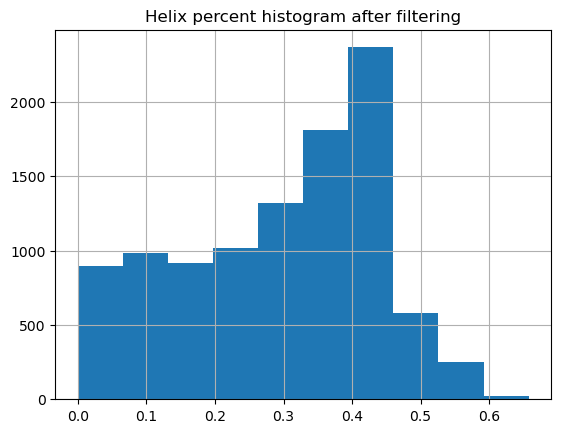

In [12]:
ax = train_csv.helix_percent.hist()
ax.set_title('Helix percent histogram after filtering')